# Michigan Accident Risk Modeling
Build a Random Forest model to predict accident risk levels (Low, Medium, High) for Michigan. The workflow covers resampling, SMOTE, hyperparameter tuning, and threshold tuning focused on risk detection.

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')


## 1. Load Data

In [25]:
# Load data
df = pd.read_csv(r"C:\Users\osiri\Downloads\US_Accidents_March23_sampled_500k.csv")
df = df[df['State'] == 'MI']  # Filter for Michigan

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
df.head()

Dataset shape: (10518, 46)

Column names:
['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
28,A-2826531,Source2,2,2018-05-16 17:45:34,2018-05-16 18:14:43,42.442745,-83.754082,NaN,NaN,0.000,Left lane blocked due to accident on US-23 Nor...,US-23 N,Brighton,Livingston,MI,48116,US,US/Eastern,KOZW,2018-05-16 17:55:00,76.8,NaN,40.0,29.97,10.0,NNW,3.5,NaN,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
78,A-191738,Source2,2,2016-09-02 18:55:39,2016-09-02 19:25:39,42.974300,-83.679016,NaN,NaN,0.000,Accident on Bristol Rd near Greenly St.,Greenly St,Burton,Genesee,MI,48529,US,US/Eastern,KFNT,2016-09-02 18:53:00,69.1,NaN,58.0,30.24,10.0,ENE,11.5,NaN,Scattered Clouds,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
106,A-3015356,Source2,3,2018-02-16 16:16:50,2018-02-16 16:46:14,43.075649,-83.762894,NaN,NaN,0.000,Accident on I-75 Southbound at W Carpenter Rd.,US-23 S,Flint,Genesee,MI,48504,US,US/Eastern,KFNT,2018-02-16 15:53:00,30.0,20.0,54.0,30.21,10.0,WNW,12.7,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
244,A-4425234,Source1,2,2023-01-23 01:53:49.000000000,2023-01-23 04:01:09.000000000,42.332135,-83.085748,42.332055,-83.079628,0.313,EB I-96 Ramp to M-10,I-75,Detroit,Wayne,MI,48216,US,US/Eastern,KDET,2023-01-23 01:53:00,31.0,25.0,85.0,29.16,6.0,NNW,6.0,0.0,Cloudy,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Night
278,A-2418250,Source2,3,2018-12-28 19:01:12,2018-12-28 19:45:47,42.228817,-83.616928,NaN,NaN,0.000,Right lane blocked due to accident on I-94 Eas...,Huron Rd,Ypsilanti,Washtenaw,MI,48197,US,US/Eastern,KYIP,2018-12-28 18:53:00,37.0,27.7,73.0,29.88,10.0,West,16.1,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night


## 2. Explore Data & Create Target
Inspect the dataset and create the three-level target variable (`Risk_Level`).

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10518 entries, 28 to 499991
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     10518 non-null  object 
 1   Source                 10518 non-null  object 
 2   Severity               10518 non-null  int64  
 3   Start_Time             10518 non-null  object 
 4   End_Time               10518 non-null  object 
 5   Start_Lat              10518 non-null  float64
 6   Start_Lng              10518 non-null  float64
 7   End_Lat                4524 non-null   float64
 8   End_Lng                4524 non-null   float64
 9   Distance(mi)           10518 non-null  float64
 10  Description            10518 non-null  object 
 11  Street                 10511 non-null  object 
 12  City                   10518 non-null  object 
 13  County                 10518 non-null  object 
 14  State                  10518 non-null  object 
 15  Zipco

In [27]:
df['Severity'].value_counts()

Severity
2    7344
3    2601
4     497
1      76
Name: count, dtype: int64

In [28]:
df['Risk_Level'] = pd.cut(df['Severity'], bins=[0, 1, 2, 3], labels=['Low', 'Medium', 'High'])
df['Risk_Level'].value_counts()   

Risk_Level
Medium    7344
High      2601
Low         76
Name: count, dtype: int64

## 3. Balance Classes 
Undersample Medium by half and oversample Low to reduce imbalance.

In [30]:
# Balance the dataset

# Step 1: Undersample Medium by half
medium = df[df['Risk_Level'] == 'Medium']
high = df[df['Risk_Level'] == 'High']
low = df[df['Risk_Level'] == 'Low']

medium_undersampled = resample(medium, n_samples=len(medium)//2, random_state=42)

# Combine after undersampling
df_balanced = pd.concat([high, medium_undersampled, low])

print("After undersampling Medium:")
print(df_balanced['Risk_Level'].value_counts())

#oversample low to match others
low_oversampled = resample(low, replace=True, n_samples=1300, random_state=42)
df_balanced = pd.concat([high, medium_undersampled, low_oversampled])
print("After resampling:")
print(df_balanced['Risk_Level'].value_counts())


After undersampling Medium:
Risk_Level
Medium    3672
High      2601
Low         76
Name: count, dtype: int64
After resampling:
Risk_Level
Medium    3672
High      2601
Low       1300
Name: count, dtype: int64


## 4. Feature Selection & Missing Values
Select modeling features and drop rows with missing values.

In [31]:
missing = df_balanced.isnull().sum()
print("Missing values per column:\n", missing[missing > 0])
print(df_balanced.shape)

Missing values per column:
 End_Lat                  5327
End_Lng                  5327
Street                      5
Weather_Timestamp           7
Temperature(F)             15
Wind_Chill(F)            1778
Humidity(%)                19
Pressure(in)               11
Visibility(mi)             21
Wind_Direction             28
Wind_Speed(mph)           291
Precipitation(in)        2454
Weather_Condition          11
Sunrise_Sunset              6
Civil_Twilight              6
Nautical_Twilight           6
Astronomical_Twilight       6
dtype: int64
(7573, 47)


In [32]:
df_model = df_balanced[["Risk_Level", "City", "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)",
                         "Wind_Direction", "Wind_Speed(mph)", "Precipitation(in)", "Sunrise_Sunset"]]
print(f"Modeling dataset shape: {df_model.shape}")

Modeling dataset shape: (7573, 11)


In [33]:
missing = df_model.isnull().sum()
print("Missing values per column:\n", missing[missing > 0])
df_model = df_model.dropna()
print(f"Modeling dataset shape after dropping missing: {df_model.shape}")
print("Missing values per column after dropping:\n", df_model.isnull().sum())

Missing values per column:
 Temperature(F)         15
Wind_Chill(F)        1778
Humidity(%)            19
Pressure(in)           11
Visibility(mi)         21
Wind_Direction         28
Wind_Speed(mph)       291
Precipitation(in)    2454
Sunrise_Sunset          6
dtype: int64
Modeling dataset shape after dropping missing: (4864, 11)
Missing values per column after dropping:
 Risk_Level           0
City                 0
Temperature(F)       0
Wind_Chill(F)        0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Direction       0
Wind_Speed(mph)      0
Precipitation(in)    0
Sunrise_Sunset       0
dtype: int64


In [35]:
X = df_model.drop(['Risk_Level'], axis=1)
y = df_model['Risk_Level']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:\n{X.columns.tolist()}")

Features shape: (4864, 10)
Target shape: (4864,)

Feature columns:
['City', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Sunrise_Sunset']


## 5. Encode Categoricals & Split
Label-encode categorical features, then split into train/test.

In [36]:
# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {categorical_cols}")

label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"\nEncoded features shape: {X_encoded.shape}")
print(X_encoded.head())

Categorical columns to encode: ['City', 'Wind_Direction', 'Sunrise_Sunset']

Encoded features shape: (4864, 10)
      City  Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  \
1416    87            69.0           69.0         81.0         29.05   
1446    11            85.0           85.0         53.0         29.21   
2230   169            92.0           92.0         41.0         29.19   
2305    49            50.0           50.0         48.0         29.46   
3500   151            66.0           66.0         87.0         29.08   

      Visibility(mi)  Wind_Direction  Wind_Speed(mph)  Precipitation(in)  \
1416            10.0              11              8.0               0.00   
1446            10.0              13              7.0               0.00   
2230            10.0              14              7.0               0.00   
2305            10.0              20             13.0               0.00   
3500             5.0              12              7.0               0.01   

In [37]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set distribution:")
print(y_train.value_counts())

Training set size: 3891
Test set size: 973

Training set distribution:
Risk_Level
Medium    1942
Low       1040
High       909
Name: count, dtype: int64


## 6. SMOTE on Training Set
Apply SMOTE only to the training data to avoid leakage.

In [38]:
# Apply SMOTE to balance training data
smote = SMOTE(sampling_strategy={
    'Low': 1300,  # Target ~1,300 Low samples
}, random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE on training data:")
print(y_train_smote.value_counts())
print(f"\nNew training set size: {X_train_smote.shape[0]}")

After SMOTE on training data:
Risk_Level
Medium    1942
Low       1300
High       909
Name: count, dtype: int64

New training set size: 4151


## 7. Hyperparameter Tuning
Grid search to find the best Random Forest settings using F1-weighted.

In [39]:
# Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

grid_search = GridSearchCV(rf_grid, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)

print("Starting GridSearchCV... (this may take a few minutes)")
grid_search.fit(X_train_smote, y_train_smote)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-Score: {grid_search.best_score_:.4f}")

Starting GridSearchCV... (this may take a few minutes)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation F1-Score: 0.7860


## 8. Train Optimized Model & Evaluate

In [40]:
# Train optimized Random Forest with best parameters
rf_model = grid_search.best_estimator_

# Make predictions
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)

# Evaluate
print("Optimized Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, rf_pred, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

Optimized Random Forest Results:
Accuracy: 0.7739
F1-Score (weighted): 0.7661

Classification Report:
              precision    recall  f1-score   support

        High       0.53      0.43      0.47       227
         Low       0.97      1.00      0.99       260
      Medium       0.76      0.81      0.78       486

    accuracy                           0.77       973
   macro avg       0.75      0.75      0.75       973
weighted avg       0.76      0.77      0.77       973



## 9. Confusion Matrix

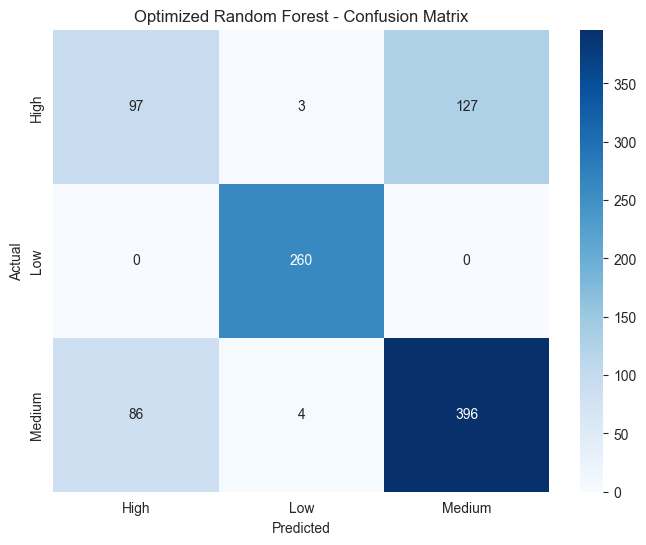

In [41]:
# Confusion Matrix for Optimized Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title('Optimized Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 10. Threshold Tuning (High Risk)
Optimize the probability threshold to improve High-risk recall and F1.

Class labels: ['High' 'Low' 'Medium']
Class indices: {0: 'High', 1: 'Low', 2: 'Medium'}

High class index: 0

Threshold Tuning Results:
    Threshold  Precision    Recall        F1
0        0.10   0.325615  0.991189  0.490196
1        0.15   0.353407  0.982379  0.519814
2        0.20   0.383392  0.955947  0.547289
3        0.25   0.417166  0.920705  0.574176
4        0.30   0.452381  0.837004  0.587326
5        0.35   0.484594  0.762115  0.592466
6        0.40   0.509025  0.621145  0.559524
7        0.45   0.521127  0.488987  0.504545
8        0.50   0.553571  0.409692  0.470886
9        0.55   0.652893  0.348018  0.454023
10       0.60   0.653846  0.224670  0.334426
11       0.65   0.678571  0.167401  0.268551
12       0.70   0.718750  0.101322  0.177606
13       0.75   0.900000  0.039648  0.075949
14       0.80   0.833333  0.022026  0.042918
15       0.85   1.000000  0.013216  0.026087
16       0.90   1.000000  0.008811  0.017467
17       0.95   0.000000  0.000000  0.000000

Best Thr

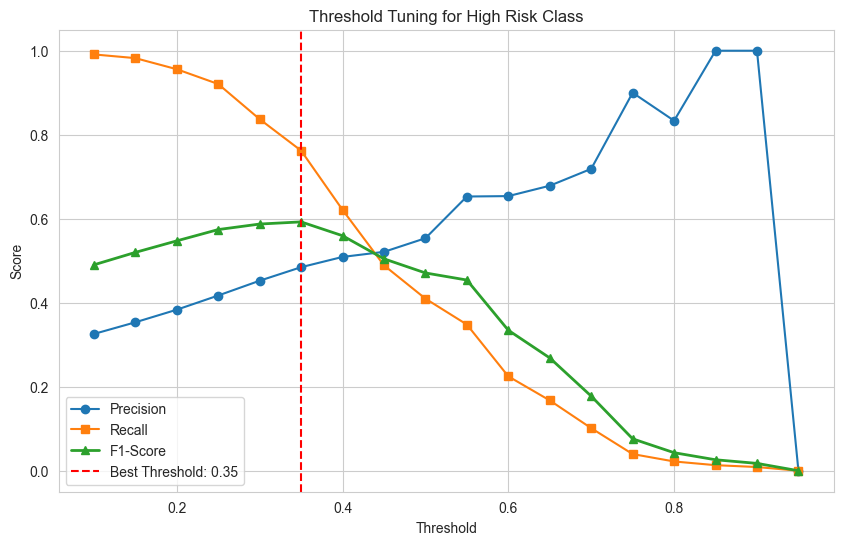

In [42]:
# Threshold Tuning for High Risk Class

# Encode y_test for threshold tuning
le_final = LabelEncoder()
y_test_encoded = le_final.fit_transform(y_test)
class_labels = le_final.classes_

print(f"Class labels: {class_labels}")
print(f"Class indices: {dict(enumerate(class_labels))}")

# Identify the index for 'High' in the model's class order
high_class_idx = list(class_labels).index('High')
print(f"\nHigh class index: {high_class_idx}")

# Get probability predictions for High class
high_probabilities = rf_pred_proba[:, high_class_idx]

# Test different thresholds
thresholds = np.arange(0.1, 1.0, 0.05)
results = []

for threshold in thresholds:
    # Create binary predictions (High vs Not High)
    y_pred_binary = (high_probabilities >= threshold).astype(int)
    y_test_binary = (y_test_encoded == high_class_idx).astype(int)
    
    # Calculate metrics
    from sklearn.metrics import precision_score, recall_score
    precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_test_binary, y_pred_binary, zero_division=0)
    
    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

# Find best threshold
results_df = pd.DataFrame(results)
best_threshold_idx = results_df['F1'].idxmax()
best_threshold = results_df.loc[best_threshold_idx, 'Threshold']
best_f1 = results_df.loc[best_threshold_idx, 'F1']

print("\nThreshold Tuning Results:")
print(results_df.to_string())
print(f"\nBest Threshold: {best_threshold:.2f}")
print(f"Best F1-Score for High class: {best_f1:.4f}")

# Plot threshold tuning
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Precision'], marker='o', label='Precision')
plt.plot(results_df['Threshold'], results_df['Recall'], marker='s', label='Recall')
plt.plot(results_df['Threshold'], results_df['F1'], marker='^', label='F1-Score', linewidth=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning for High Risk Class')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
# Apply Optimized Threshold and Evaluate

# For multi-class, start with the original predictions
y_pred_tuned = rf_pred.copy()

# Promote to High when probability exceeds the optimized threshold
high_pred_indices = np.where(high_probabilities >= best_threshold)[0]
for idx in high_pred_indices:
    y_pred_tuned[idx] = 'High'

# If originally predicted High but below threshold, reassign to best non-High class
non_high_indices = [i for i, label in enumerate(class_labels) if label != 'High']
non_high_labels = [class_labels[i] for i in non_high_indices]

low_pred_indices = np.where(high_probabilities < best_threshold)[0]
for idx in low_pred_indices:
    if rf_pred[idx] == 'High':
        other_probs = rf_pred_proba[idx][non_high_indices]
        best_non_high_idx = np.argmax(other_probs)
        y_pred_tuned[idx] = non_high_labels[best_non_high_idx]

print("Results with Optimized Threshold:")
print(f"Threshold: {best_threshold:.2f}")
print(f"\nClassification Report (Threshold-Tuned):")
print(classification_report(y_test, y_pred_tuned))

# Compare before and after
print("\n" + "="*60)
print("COMPARISON: Default vs Threshold-Tuned")
print("="*60)
print("\nDefault Threshold (0.5):")
print(classification_report(y_test, rf_pred, digits=4))
print("\nOptimized Threshold ({:.2f}):".format(best_threshold))
print(classification_report(y_test, y_pred_tuned, digits=4))


Results with Optimized Threshold:
Threshold: 0.35

Classification Report (Threshold-Tuned):
              precision    recall  f1-score   support

        High       0.48      0.76      0.59       227
         Low       0.98      1.00      0.99       260
      Medium       0.85      0.61      0.71       486

    accuracy                           0.75       973
   macro avg       0.77      0.79      0.76       973
weighted avg       0.80      0.75      0.76       973


COMPARISON: Default vs Threshold-Tuned

Default Threshold (0.5):
              precision    recall  f1-score   support

        High     0.5301    0.4273    0.4732       227
         Low     0.9738    1.0000    0.9867       260
      Medium     0.7572    0.8148    0.7849       486

    accuracy                         0.7739       973
   macro avg     0.7537    0.7474    0.7483       973
weighted avg     0.7621    0.7739    0.7661       973


Optimized Threshold (0.35):
              precision    recall  f1-score   suppo

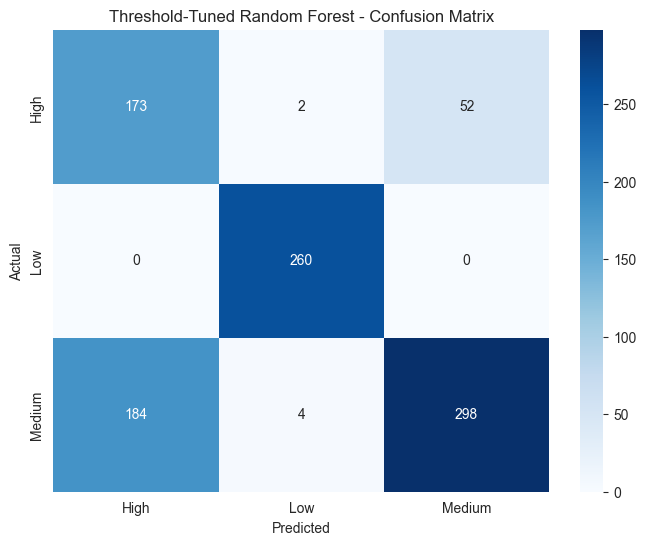

In [44]:
# Confusion Matrix for Threshold-Tuned Predictions
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
plt.title('Threshold-Tuned Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## Threshold-Tuned Confusion Matrix

## 11. Feature Importance

Top 10 Most Important Features:
             Feature  Importance
2      Wind_Chill(F)    0.172774
1     Temperature(F)    0.166812
4       Pressure(in)    0.160702
3        Humidity(%)    0.126186
0               City    0.125542
7    Wind_Speed(mph)    0.092169
6     Wind_Direction    0.073445
5     Visibility(mi)    0.046358
9     Sunrise_Sunset    0.019647
8  Precipitation(in)    0.016367


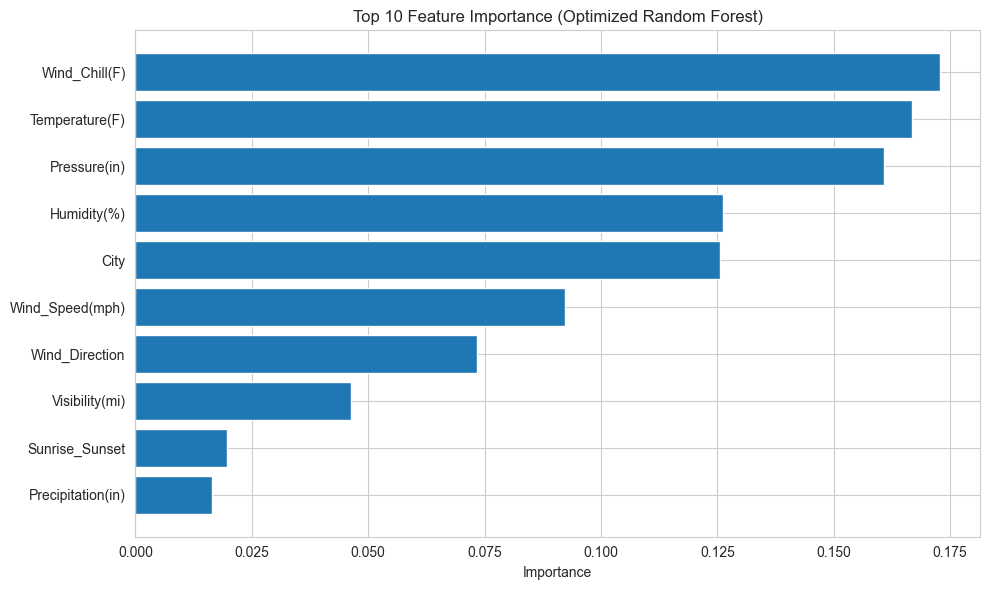

In [45]:
# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance (Optimized Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()